## Computer Vision and Cognitive Systems Group Project
### Virtual Try-On Complete Pipeline Execution
Group #13: Francesco Sala, Francesco Martucci, Felicia Puzone \
2022/2023

This demo aims to show the execution flow of the project pipeline. We start from some input images and progress step-by-step to the output image.


> Let us have a person image and a cloth image. The main goal is to replace the upper body cloth with the selected in-shop garment.



> First of all, let us import the git application repository and the python packages.



In [1]:
!git clone https://github.com/felicia-puzone/virtual-try-on-app.git

Cloning into 'virtual-try-on-app'...
remote: Enumerating objects: 699, done.
remote: Counting objects: 100% (699/699), done.
remote: Compressing objects: 100% (571/571), done.
remote: Total 699 (delta 118), reused 690 (delta 112), pack-reused 0
Receiving objects: 100% (699/699), 3.98 MiB | 18.19 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [2]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

For visualization:

In [3]:
def plot_img_list(img_list):
    k = len(img_list)
    figure, ax = plt.subplots(nrows=1, ncols=k, figsize=(6, 6))

    for index in range(k):
        ax[index].imshow(img_list[index])

    figure.tight_layout()
    figure.show()
    plt.show()

> From the folder _input-images_, we first try the app on some images taken from the dataset DressCode, on which the application was trained.



In [6]:
%cd virtual-try-on-app/

/content/virtual-try-on-app


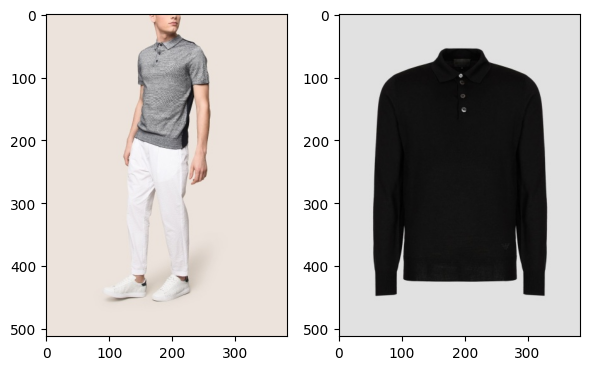

In [7]:
person_image = cv2.imread(r"input_images/people/000179_0.jpg")
cloth_image = cv2.imread(r"input_images/garments/000050_1.jpg")

person_image = cv2.cvtColor(person_image, cv2.COLOR_BGR2RGB)
cloth_image = cv2.cvtColor(cloth_image, cv2.COLOR_BGR2RGB)

show_list = [person_image, cloth_image]

plot_img_list(show_list)



> We apply some contrast adjusting and a bilateral filter to smooth the images.
 ### Contrast stretching
 $I_o = (I_i - min_i)*((max_o - min_o)/(max_i - min_i)) + min_o$

**Contrast stretching** is a simple image enhancement technique that attempts to improve the contrast in an image by `stretching' the range of intensity values it contains to span a desired range of values

A **bilateral filter** is a non-linear, edge-preserving, and noise-reducing smoothing filter for images. We believed this filter could enhance image quality and make them more like the training image examples.


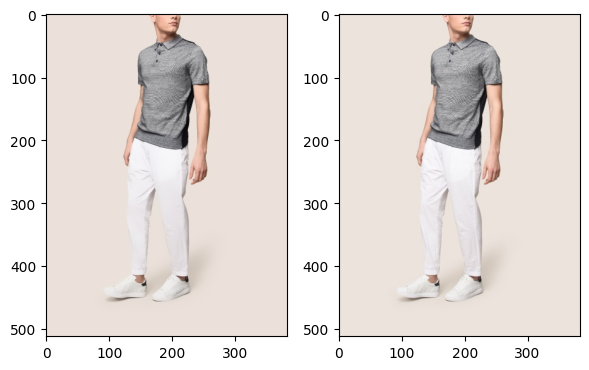

In [8]:
def ContrastStretching(img, min_o = 0, max_o = 255):

  out = (img - img.min())*((max_o - min_o)/(img.max() - img.min())) + min_o
  return out.astype(img.dtype)

person_image_proc = ContrastStretching(person_image)

person_image_proc = cv2.bilateralFilter(person_image_proc, 20, 15, 15)

show_list = [person_image_proc, person_image]


plot_img_list(show_list)


## SCHP

Downloading atr SCHP checkpoints

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
!pip install ninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 2.4 MB/s eta 0:00:00


In [11]:
os.getcwd()

'/content/virtual-try-on-app'

In [12]:
%cd people-preprocessing/

!python simple_extractor.py --dataset 'atr' --input-dir ./../input_images/people --output-dir ./../results/segmentation-output --model-restore ./../../gdrive/MyDrive/exp-schp-201908301523-atr.pth



/content/virtual-try-on-app/people-preprocessing
Evaluating total class number 18 with ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']
100% 2/2 [00:06<00:00,  3.35s/it]


In [15]:
%cd ..

/content/virtual-try-on-app


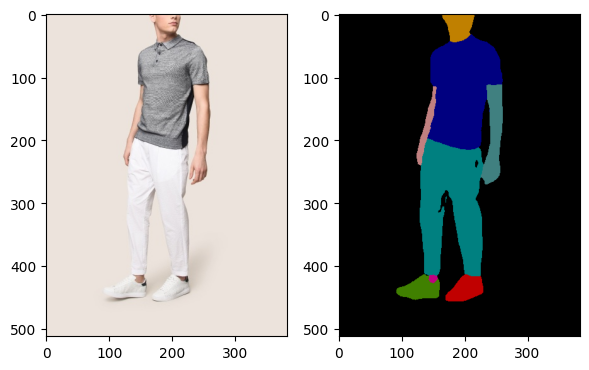

In [16]:
#%cd ..
labels_image = cv2.imread(r"./results/segmentation-output/000179_4.png")
labels_image = cv2.cvtColor(labels_image, cv2.COLOR_BGR2RGB)

show_list = [person_image, labels_image]

plot_img_list(show_list)

## Mask Image Generation
Now that we have the label map, we can use a simple function to generate the people mask, needed as input for the geometric and generative modules.

In [17]:
os.getcwd()

'/content/virtual-try-on-app'

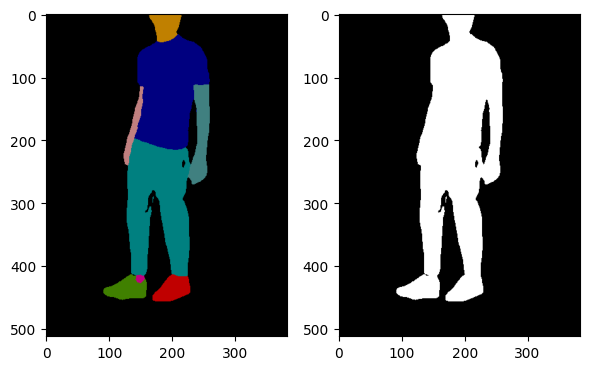

In [18]:
def get_mask_from_labels(img):

    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img[img != 0] = 255
    return img

mask_image = get_mask_from_labels(labels_image)

cv2.imwrite('./results/people-mask-output/000179_0.png', mask_image)

show_list = [labels_image, cv2.cvtColor(mask_image, cv2.COLOR_GRAY2RGB)]

plot_img_list(show_list)


## OPENPOSE


In [ ]:
import subprocess
import os

%cd openpose

os.getcwd()

os.system("bin\OpenPoseDemo.exe --image_dir ./../input_images  --write_json ./../results")

%cd ..

#

## Cloth mask generation